In [1]:
# Installing libraries
!pip install -q ydata-profiling
!pip install -q pywaffle
!pip install -q highlight-text
!pip install -q pillow
!pip install -q yellowbrick

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import os
import yellowbrick
import joblib

from ydata_profiling import ProfileReport
from pywaffle import Waffle
from highlight_text import fig_text
from PIL import Image
from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score

from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.style import set_palette


In [3]:
df = pd.read_csv('Dataset/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
ProfileReport(df,title='Heart Disease Dataset Report')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

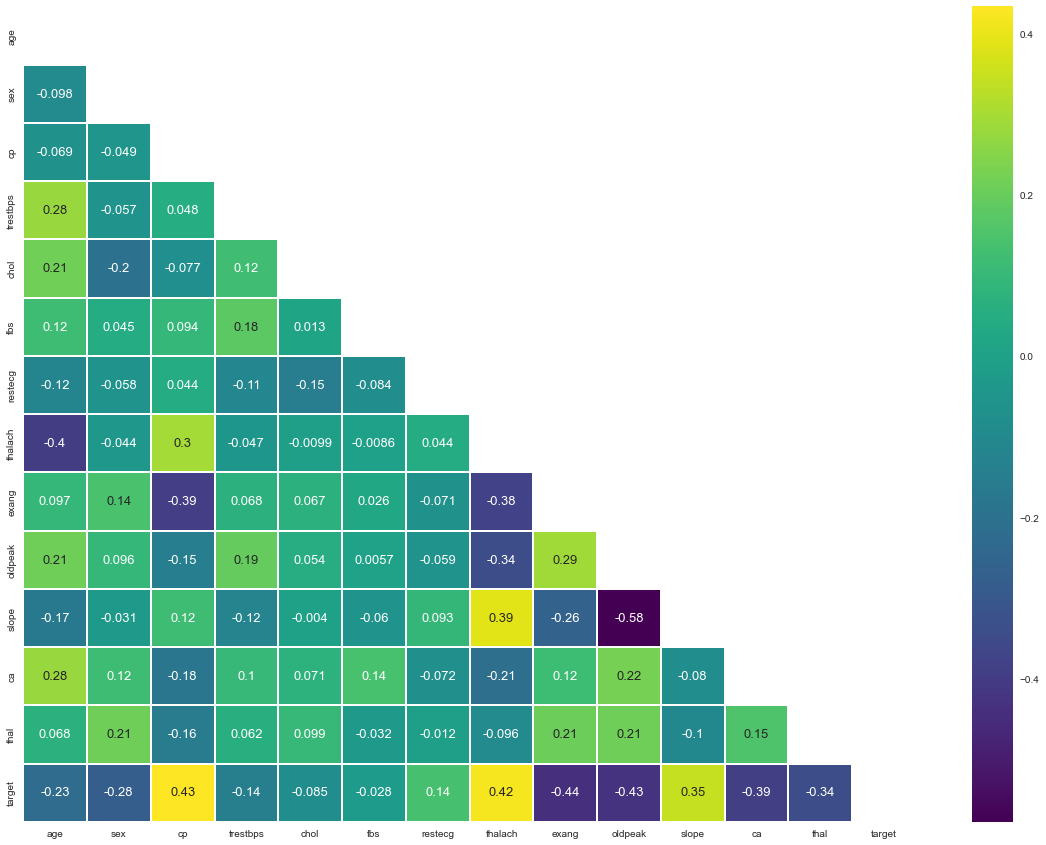

In [5]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax =plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, linewidths=0.2,mask=mask, annot_kws={"size": 13}, cmap='viridis')

The number of male patient is greater than female patient.

## EDA

### Disease Distribution based on Chest Pain Type in Each Gender

<AxesSubplot:xlabel='cp', ylabel='target'>

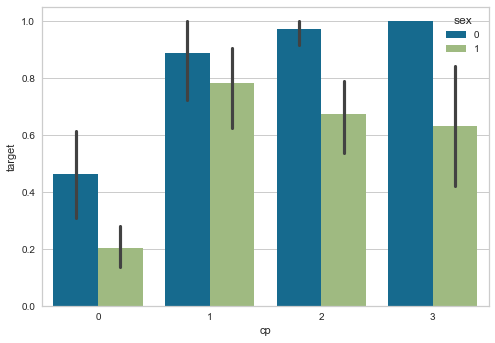

In [6]:
sns.barplot(data=df, x='cp', y='target', hue='sex')

0 -> Typical Angina
1 -> Atypical Angina
2 -> Non-anginal pain
3 -> Asymtomatic. 
Here, it is shown that number of male patient is greater than female patients.

### Max Heart Rate vs. Age based on Patients Sickness

<AxesSubplot:xlabel='thalach', ylabel='age'>

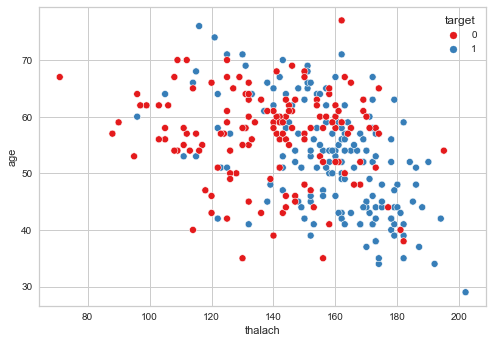

In [7]:
sns.scatterplot(data=df, x='thalach', y='age', hue='target', palette='Set1')


The scatterplot above shows that patients are aged between 40 to 70 years old. In addition, max.patients heart rate ranges from 140 to 180. It can also be seen that age and max.heart rate are negatively correlated.  

### Fasting Blood Sugar Distribution by Resting ECG Results

###  Number of Major Vessles Distribution based on Exercise Induced Angina

### Resting Blood Pressure Distribution based on Slope

# Data Preprocessing

In [8]:
x = df.drop(['target'], axis=1)
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### Processing Pipeline

In [9]:
# Numerical Pipeline
num_column = ['age','trestbps','chol','thalach','oldpeak']
num_pipeline = Pipeline([
        ('scaling', RobustScaler())
])

#Categorical Pipeline
cat_column = ['cp','slope','thal']
cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(drop='first', sparse=False))
])

# Combines both pipelines into Transformer
preprocessor = ColumnTransformer([
        ('categorical', cat_pipeline, cat_column),
        ('numerical', num_pipeline, num_column)],
        remainder = 'passthrough'
)

#Apply Transformer to Pipeline
process_pipeline = Pipeline([
        ('preprocessor',preprocessor)
])

#Apply to Dataframe
x_train_process = process_pipeline.fit_transform(x_train) 
x_test_process = process_pipeline.fit_transform(x_test)

### Model Implementation

We will implement various machine learning models on the dataset to choose the best one for prediction.

In [10]:
# Functions: Model fitting and Perfomance evaluations
from IPython.display import HTML
def fit_ml_models(algo, algo_param, algo_name):
    
    # algorithm pipeline
    algo = Pipeline([('algo',algo)])
    
    # apply Grid Search
    model = GridSearchCV(algo, param_grid=algo_param, cv=10, n_jobs=-1, verbose=1)
    
    # fitting Model
    display(HTML(f"<b>.:. Fitting {algo_name} .:.</b>"))
    fit_model = model.fit(x_train_process, y_train)
          
    # model Best Parameters
    best_params = model.best_params_
    print("\n>> Best Parameters: " + f"{best_params}")
    
    # Best and final estimators
    best_model = model.best_estimator_
    best_estimator = model.best_estimator_._final_estimator
    best_score = round(model.best_score_, 4)
    print(">> Best Score: "+"{:.3f}".format(best_score))
    
    # Create prediction for Train & Test
    y_pred_train = model.predict(x_train_process) 
    y_pred_test = model.predict(x_test_process)
          
    # Train & Test accuracy score
    acc_score_train = round(accuracy_score(y_pred_train, y_train)*100, 3)
    acc_score_test = round(accuracy_score(y_pred_test, y_test)*100, 3)
          
    display(HTML(f"<b>.:. Train and Test Accuracy Score for {algo_name} .:.</b>"))
    print("\t>> Train Accuracy: "+"{:.2f}%".format(acc_score_train))
    print("\t>> Test Accuracy: "+"{:.2f}%".format(acc_score_test))
    
    # Classification Report 
    display(HTML(f"<b>.:. Classification Report for {algo_name} .:.</b>"))
    print(classification_report(y_test, y_pred_test))
    
    # Confusion Metrix
    fig, ax1 = plt.subplots( figsize=(4, 4))
    conf_matrix = ConfusionMatrix(best_estimator, ax=ax1, cmap='Reds')
    conf_matrix.fit(x_train_process, y_train)
    conf_matrix.score(x_test_process, y_test)
    conf_matrix.finalize()
    
    # Feature Importance or Precision Recall value
    '''
    try:
        feat_importance = FeatureImportances(best_estimator, labels=columns_list_onehot, ax=ax2, topn=5, colors=color_yb_importance)
        feat_importance.fit(x_train_process, y_train)
        feat_importance.finalize()
        feat_importance.ax.grid(axis='y', alpha=0, **grid_style)
        for spine in feat_importance.ax.spines.values(): spine.set_color('None')
        for spine in ['bottom']:
            feat_importance.ax.spines[spine].set_visible(True)
            feat_importance.ax.spines[spine].set_color(color_line)
    except:
        prec_curve = PrecisionRecallCurve(best_estimator, ax=ax2, ap_score=True, iso_f1_curves=True)
        prec_curve.fit(x_train_process, y_train)
        prec_curve.score(x_test_process, y_test)
        prec_curve.finalize()
        '''
    
    return acc_score_train, acc_score_test, best_score
    

#### 1. Logistic Regression

Logistic Regression is a statistical method that is used for building machine learning models where the dependent varible is Binary.
The name 'Logistic Regression' is derived from the concept of logistic function that it uses. The logistic function is also known as the Sigmoid function. The value of logistic function lies between 0 and 1.

Fitting 10 folds for each of 12 candidates, totalling 120 fits

>> Best Parameters: {'algo__C': 0.5, 'algo__solver': 'lbfgs'}
>> Best Score: 0.823


	>> Train Accuracy: 85.95%
	>> Test Accuracy: 90.16%


              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



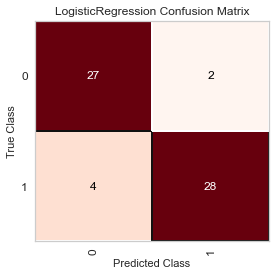

In [11]:
# Logistic Regression Parameters
parameter_lr = {'algo__solver': ['lbfgs', 'saga', 'newton-cg'],
                'algo__C': [0.1, 0.2, 0.5, 0.8]}

# Logistic Regression Algorithm
algo_lr = LogisticRegression(penalty='l2', random_state=42, n_jobs=-1)

# Applying Logistic Regression
acc_score_train_lr, acc_score_test_lr, best_score_lr = fit_ml_models(algo_lr, parameter_lr, "Logistic Regression")


The k-nearest neighbor algorithm is a type of supervised machine learning algorithm used to solve classification and regression problems. It is a data classification method for estimating the likelihood that a data point will become a member of one group or another based on what group the data points nearest to it belong to.

It's called a lazy learning algorithm or lazy learner because it doesn't perform any training when you supply the training data. Instead, it just stores the data during the training time and doesn't perform any calculations. It doesn't build a model until a query is performed on the dataset. This makes KNN ideal for data mining.

Fitting 10 folds for each of 16 candidates, totalling 160 fits

>> Best Parameters: {'algo__leaf_size': 1, 'algo__n_neighbors': 17}
>> Best Score: 0.819


	>> Train Accuracy: 83.47%
	>> Test Accuracy: 85.25%


              precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



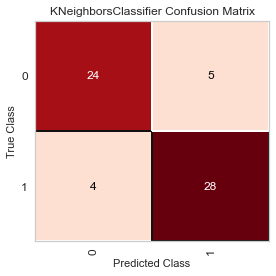

In [12]:
# KNN Parameters
parameter_knn = {'algo__n_neighbors': [2, 5, 10, 17],
                 'algo__leaf_size': [1, 10, 11, 30]}
# KNN Algorithm
algo_knn = KNeighborsClassifier(n_jobs=-1)

# Apply KNN
acc_score_train_knn, acc_score_test_knn, best_score_knn = fit_ml_models(algo_knn, parameter_knn, 'K-Nearest Neighbour(KNN)')


### Support Vector Machine(SVM) 

Support Vector Machine (SVM) is one of the most popular Supervised Learning algorithms, which is used for Classification as well as Regression problems. The goal of the SVM algorithm is to create the best line or hyperplane that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future.

Fitting 10 folds for each of 171 candidates, totalling 1710 fits

>> Best Parameters: {'algo__C': 0.9, 'algo__kernel': 'linear'}
>> Best Score: 0.835


	>> Train Accuracy: 85.12%
	>> Test Accuracy: 83.61%


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



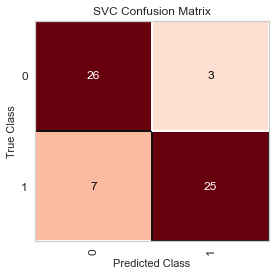

In [13]:
# SVM Parameters
parameter_svc = [
    {'algo__kernel': ['rbf'], 'algo__gamma': np.arange(0.1, 1, 0.1), 'algo__C': np.arange(0.1, 1, 0.1)}
    ,{'algo__kernel': ['linear'], 'algo__C': np.arange(0.1, 1, 0.1)}
    ,{'algo__kernel': ['poly'], 'algo__degree': np.arange(1, 10, 1), 'algo__C': np.arange(0.1, 1, 0.1)}
]

# SVM Algorithm
algo_svc = SVC(random_state=1, probability=True)

# Applying SVM
acc_score_train_svc, acc_score_test_svc, best_score_svc = fit_ml_models(algo_svc, parameter_svc, 'Support Vector Machine(SVM)')


### Gaussian Naive Bayes

Naive Bayes is a family of probabilistic machine learning algorithms based on Bayes' theorem. The "naive" in Naive Bayes comes from the assumption that features used in the classification are conditionally independent of each other given the class label, which simplifies the computation and makes the algorithm more tractable. 

Gaussian Naive Bayes is a variant of Naive Bayes that follows Gaussian normal distribution and supports continuous data. When working with continuous data, an assumption often taken is that the continuous values associated with each class are distributed according to a normal (or Gaussian) distribution.

Fitting 10 folds for each of 4 candidates, totalling 40 fits

>> Best Parameters: {'algo__var_smoothing': 0.01}
>> Best Score: 0.830


	>> Train Accuracy: 85.95%
	>> Test Accuracy: 86.89%


              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



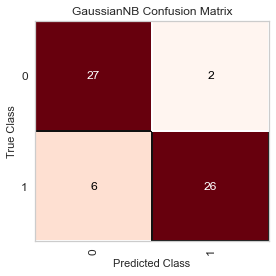

In [14]:
# Gaussian NB Parameters
parameter_gnb = {'algo__var_smoothing': [1e-2, 1e-3, 1e-4, 1e-6]}

# Gaussian NB Algorithm
algo_gnb = GaussianNB()

# Applying Gaussian NB
acc_score_train_gnb, acc_score_test_gnb, best_score_gnb = fit_ml_models(algo_gnb, parameter_gnb, 'Gaussian Naive Bayes')


### Decision Tree

Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

Fitting 10 folds for each of 3 candidates, totalling 30 fits

>> Best Parameters: {'algo__max_depth': 1}
>> Best Score: 0.756


	>> Train Accuracy: 75.62%
	>> Test Accuracy: 80.33%


              precision    recall  f1-score   support

           0       0.76      0.86      0.81        29
           1       0.86      0.75      0.80        32

    accuracy                           0.80        61
   macro avg       0.81      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61



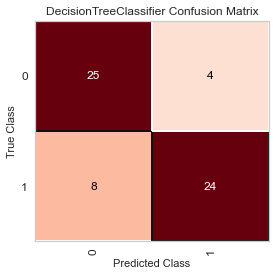

In [15]:
# Decision Tree Parameters
parameter_dt = {'algo__max_depth': [1, 2, 3]}

# Decision Tree Algorithm
algo_dt = DecisionTreeClassifier(random_state=42)

# Applying Decision Tree
acc_score_train_dt, acc_score_test_dt, best_score_dt = fit_ml_models(algo_dt, parameter_dt, 'Decision Tree')


### Random Forest

Random Forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction. 

Fitting 10 folds for each of 5 candidates, totalling 50 fits

>> Best Parameters: {'algo__max_depth': 3}
>> Best Score: 0.831


	>> Train Accuracy: 87.60%
	>> Test Accuracy: 86.89%


              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



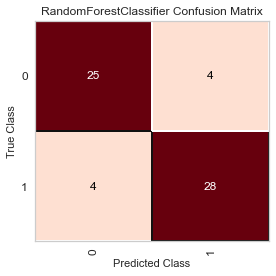

In [16]:
# Random Forest Parameters
parameter_rf = {'algo__max_depth': np.arange(1, 6, 1)}

# Random Forest Algorithm
algo_rf = RandomForestClassifier(random_state=99, n_jobs=-1)

# Applying Random Forest
acc_score_train_rf, acc_score_test_rf, best_score_rf = fit_ml_models(algo_rf, parameter_rf, 'Random Forest')


### Extra Tree Classifier

Extra Trees Classifier is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a "forest" to output it’s classification result. In concept, it is very similar to a Random Forest Classifier and only differs from it in the manner of construction of the decision trees in the forest.

Each Decision Tree in the Extra Trees Forest is constructed from the original training sample. Then, at each test node, each tree is provided with a random sample of k features from the feature-set from which each decision tree must select the best feature to split the data based on some mathematical criteria (typically the Gini Index). This random sample of features leads to the creation of multiple de-correlated decision trees.

Fitting 10 folds for each of 6 candidates, totalling 60 fits

>> Best Parameters: {'algo__max_depth': 3, 'algo__max_leaf_nodes': 7}
>> Best Score: 0.818


	>> Train Accuracy: 84.71%
	>> Test Accuracy: 83.61%


              precision    recall  f1-score   support

           0       0.77      0.93      0.84        29
           1       0.92      0.75      0.83        32

    accuracy                           0.84        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.84      0.84        61



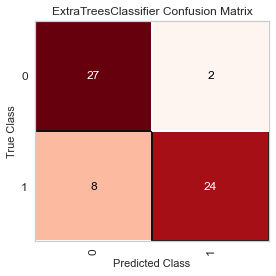

In [17]:
# Extra Tree Parameters
parameter_et = {"algo__max_depth": [2, 3]
    , "algo__max_leaf_nodes": [3, 5, 7]}

# Extra Tree Algorithm
algo_et = ExtraTreesClassifier(random_state=42, n_jobs=-1)

# Applying Extra Tree
acc_score_train_et, acc_score_test_et, best_score_et = fit_ml_models(algo_et, parameter_et, "Extra Tree Classifier")


### Gradient Boosting

Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. It strongly relies on the prediction that the next model will reduce prediction errors when blended with previous ones. The main idea is to establish target outcomes for this upcoming model to minimize errors.

Fitting 10 folds for each of 27 candidates, totalling 270 fits

>> Best Parameters: {'algo__learning_rate': 0.5, 'algo__min_weight_fraction_leaf': 0.2, 'algo__n_estimators': 6}
>> Best Score: 0.835


	>> Train Accuracy: 86.36%
	>> Test Accuracy: 83.61%


              precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



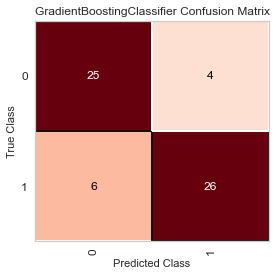

In [18]:
# --- Gradient Boosting Parameters ---
parameter_gb = {
    "algo__learning_rate": [0.1, 0.3, 0.5]
    , "algo__n_estimators": [2, 4, 6]
    , "algo__min_weight_fraction_leaf": [0.1, 0.2, 0.5]
}

# --- Gradient Boosting Algorithm ---
algo_gb = GradientBoostingClassifier(loss="exponential", random_state=2)

# --- Applying Gradient Boosting ---
acc_score_train_gb, acc_score_test_gb, best_score_gb = fit_ml_models(algo_gb, parameter_gb, "Gradient Boosting")


### AdaBoost

AdaBoost also called Adaptive Boosting is a technique in Machine Learning used as an Ensemble Method. The most common algorithm used with AdaBoost is decision trees with one level that means with Decision trees with only 1 split. These trees are also called Decision Stumps. AdaBoost builds a model and gives equal weights to all the data points. It then assigns higher weights to points that are wrongly classified. Now, all the points which have higher weights are given more importance in the next model. It will keep training models until and unless a lowe error is received.

Fitting 10 folds for each of 9 candidates, totalling 90 fits

>> Best Parameters: {'algo__learning_rate': 0.8, 'algo__n_estimators': 6}
>> Best Score: 0.831


	>> Train Accuracy: 84.30%
	>> Test Accuracy: 85.25%


              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



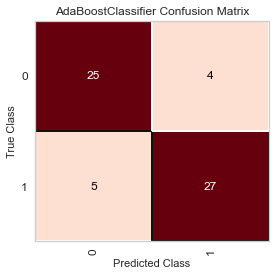

In [19]:
parameter_ab = {"algo__n_estimators": [6, 7, 10],
                "algo__learning_rate": [0.2, 0.4, 0.8]}
algo_ab = AdaBoostClassifier(random_state=1)

acc_score_train_ab, acc_score_test_ab, best_score_ab = fit_ml_models(algo_ab, parameter_ab, "AdaBoost")


## Model Comparison 

In [20]:
# Create Accuracy Comaparison Table

data = {'Model': ['Logistic Regression', 'K-Nearset Neighbour', 'Support Vector Machine', 'Gaussian NB', 'Decision Tree', 'Random Forest', 'Extra Tree Classifier', 'Gradient Boosting', 'AdaBoost'],
        'Accuracy Train': [acc_score_train_lr, acc_score_train_knn, acc_score_train_svc, acc_score_train_gnb,
                                                acc_score_train_dt, acc_score_train_rf, acc_score_train_et, acc_score_train_gb, acc_score_train_ab],
        'Accuracy Test': [acc_score_test_lr, acc_score_test_knn, acc_score_test_svc, acc_score_test_gnb,
                                               acc_score_test_dt, acc_score_test_rf, acc_score_test_et, acc_score_test_gb, acc_score_test_ab],
        'Best Score': [best_score_lr, best_score_knn, best_score_svc, best_score_gnb,best_score_dt, best_score_rf, 
                                            best_score_et, best_score_gb, best_score_ab]
        }
df_compare = pd.DataFrame(data)
display(HTML(f"<b>.:. Model Comparison .:.</b>"))
display('*' * 19)
df_compare.sort_values(by='Best Score', ascending=False)
display(HTML(df_compare.to_html(index=False)))


'*******************'

Model,Accuracy Train,Accuracy Test,Best Score
Logistic Regression,85.950,90.164,0.8230
K-Nearset Neighbour,83.471,85.246,0.8185
Support Vector Machine,85.124,83.607,0.8352
Gaussian NB,85.950,86.885,0.8303
Decision Tree,75.620,80.328,0.7563
Random Forest,87.603,86.885,0.8307
Extra Tree Classifier,84.711,83.607,0.8183
Gradient Boosting,86.364,83.607,0.8352
AdaBoost,84.298,85.246,0.8307


    From the results of the accuracy of the train and test above, most models experienced overfitting or underfitting. However, several models have a good fit, where the difference between train and test accuracy or vice versa is a little. These models are random forest, AdaBoost, Gaussian Naive Bayes, and extra tree classifier. As seen in the data frame above, of the four models, random forest and Gaussian NB have the highest accuracy compared to the other models. 
    
    Judging from the F1 scores of both models, both models do a very good job differentiating sick patients from those who are not (scores above 0.85). If seen from the precision value for Gaussian NB, 93% of all the patients that the model predicted have heart disease. Whereas in the random forest precision value, only 88% out of all the patients that the model predicted have heart disease, slightly lower than the Gaussian NB precision value. At the Gaussian NB recall value, this model only correctly predicts 81% of all heart disease patients. However, in the random forest recall value, this model can predict better than Gaussian NB, where 88% of patients are predicted to have heart disease out of all patients who do have heart disease.
    
    ST depression induced by exercise relative to rest can be important finding which can suggest underlying heart disease and may warrant further evaluation and management to reduce the risk of adverse cardiovascular events. Early detection and appropriate treatment of underlying heart disease can help prevent complications and improve cardiovascular health. 
    
    Finally, exercise-induced angina is also important because it can suggest underlying CAD and may warrant further evaluation and management to reduce the risk of adverse cardiovascular events. Individuals with exercise-induced angina may need further testing, such as stress testing or coronary angiography, to assess the extent of their coronary artery disease and determine the most appropriate treatment options.

## Creating Pipeline

This section focuses on creating complete pipeline, starting from data processing to a machine learning pipeline, using the best model concluded in the previous section and exporting it to joblib and pickle (.pkl) files. Besides that, test dataset predicted results would also be exported along with actual results in CSV and JSON files. Moreover, this section will also make predictions on dummy data (data generated using Python functions) and export them to CSV and JSON files.

### Creating Outputs

The complete pipeline will be exported in this section. The pipeline will bw stored using joblib library into joblib and pickle(.pkl) files. This section will also show the test data frame before exporting the predicted results and the actual results to the CSV and JSON files.  

In [24]:
# Complete pipeline: Preprocessor & RF
rf_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('algo', RandomForestClassifier(max_depth=3, random_state=99, n_jobs=-1))
])

# Creating directory to save file
directory = 'pipeline/'
if not os.path.exists(directory):
     os.makedirs(directory)

# Save complete pipeline (joblib and pickle)
file_name = 'pipeline_heart_disease_random_forest'
for ext in ['joblib', 'pkl']:
    joblib.dump(rf_pipeline, os.path.join(directory, f'{file_name}.{ext}'))

In [34]:
# DataFrames to create Test Output DataFrame
rf_pipeline.fit(x_train, y_train)
y_pred_rf = rf_pipeline.predict(x_test)
pred_target = pd.DataFrame(y_pred_rf, columns=['pred_target'])

x_test_output = x_test.reset_index()
actual_target = y_test.to_frame(name='actual_target').reset_index()

# Combining and creating test output DataFrame
df_test_output = pd.concat([x_test_output, actual_target, pred_target], axis=1).drop('index', axis=1)

display(HTML('<b><center>.: Sample Test Dataframe :.</center></b>'))
df_test_output.sample(n=10, random_state=0)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,actual_target,pred_target
26,59,1,3,160,273,0,0,125,0,0.0,2,0,2,0,1
35,63,1,0,130,254,0,0,147,0,1.4,1,1,3,0,0
60,50,1,0,150,243,0,0,128,0,2.6,1,0,3,0,0
28,57,1,0,165,289,1,0,124,0,1.0,1,3,3,0,0
11,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1,0
2,57,1,2,150,126,1,1,173,0,0.2,2,1,3,1,1
34,66,0,3,150,226,0,1,114,0,2.6,0,0,2,1,1
59,60,1,0,145,282,0,0,142,1,2.8,1,2,3,0,0
40,52,1,2,138,223,0,1,169,0,0.0,2,4,2,1,1
22,67,1,0,120,237,0,1,71,0,1.0,1,0,2,0,1


In [42]:
# Export to CSV and JSON files
directory = 'test_data/'
if not os.path.exists(directory):
    os.makedirs(directory)

output_name = 'test_data_heart_disease'
df_test_output.to_csv(os.path.join(directory, f'{output_name}.csv'), index=False, sep=',', encoding='utf-8')
df_test_output.to_json(os.path.join(directory, f'{output_name}.json'), orient='index')

### Prediction Case

This second section will predict the dummy data generated using Python functions. Then, the prediction results will be exported as CSV and JSON files, along with dummy data.

In [ ]:
# --- Creating Prediction Case Dataframe (50 Rows) ---
df_pred_case = create_prediction_case(x_train, 50)

# --- Creating Prediction using Best Model ---
y_pred_case = rf_pipeline.predict(df_pred_case)

# --- Combining Prediction Case Dataframe w/ Prediction ---
pred_case_target = pd.DataFrame(y_pred_case, columns=['pred_target'])
df_pred_case = pd.concat([df_pred_case, pred_case_target], axis=1)

df_pred_case.sample(n=6, random_state=24).style.apply(coloring_target_col).hide_index()


In [47]:
# --- Export to CSV and JSON Files ---
directory = 'pred_case/'
if not os.path.exists(directory):
    os.makedirs(directory)
    
pred_output_name = 'pred_case_heart_disease'
df_pred_case.to_csv(os.path.join(directory, f'{pred_output_name}.csv'), index=False, sep=',', encoding='utf-8')
df_pred_case.to_json(os.path.join(directory, f'{pred_output_name}.json'), orient='index')

NameError: name 'df_pred_case' is not defined